#Importing Libraries and Dataset

In [1]:
!pip install category-encoders
!pip install -U scikit-learn

In [2]:
import os
import sklearn
import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# from sklearn.metrics import log_loss
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive
drive.mount('/content/drive/')
working_dir = os.chdir('/content/drive/MyDrive/swiggy_case_study_dataset')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [201]:
assignments_stock = pd.read_csv('Assignment_Data.csv')
de_stock = pd.read_csv('Delivery_Partners_Data.csv')
print(assignments_stock.head())
de_stock.head()

   ORDER_ID    DE_ID  ... CUSTOMER_LAT CUSTOMER_LNG
0      2745   180976  ...    37.377569    72.832560
1      9462   280243  ...    37.380613    72.796909
2     14071   339813  ...    37.372032    72.805871
3     14442  1315348  ...    37.371380    72.819992
4     14515  1186729  ...    37.369925    72.826764

[5 rows x 17 columns]


,DE_ID,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID
0,141533,06:42,37.390427,72.849424,2019-09-20,372
1,235942,08:42,37.372289,72.885341,2020-03-15,372
2,973234,06:42,37.410268,72.853610,2018-12-21,375
3,973473,05:42,37.397067,72.872533,2018-12-21,624
4,1016546,06:42,37.425545,72.895137,2019-01-11,668


In [202]:
print(f'The size of the dataset: {assignments_stock.shape}')
print(f'Delivery executives data set size: {de_stock.shape}' )

The size of the dataset: (132394, 17)
Delivery executives data set size: (991, 6)


In [203]:
df_a = assignments_stock
df_de = de_stock
df_a.dtypes

ORDER_ID                      int64
DE_ID                         int64
ASSIGNMENT_START_TIME        object
ASSIGNMENT_END_TIME          object
reject_ind                    int64
reject_type                  object
PLACED_TIME                  object
DELIVERED_TIME               object
LASTMILE_DISTANCE           float64
FIRSTMILE_DISTANCE          float64
LAST_MILE_TIME_PREDICTED    float64
PAYOUT_MADE_TO_DE           float64
NUM_PING_COUNT_LAST10MIN      int64
LAST_PING_TIME_LAST10MIN     object
CUSTOMER_ZONE               float64
CUSTOMER_LAT                float64
CUSTOMER_LNG                float64
dtype: object

#Checking for Missing Values

In [204]:
assignments_stock.isnull().sum()

ORDER_ID                         0
DE_ID                            0
ASSIGNMENT_START_TIME            0
ASSIGNMENT_END_TIME              0
reject_ind                       0
reject_type                 124346
PLACED_TIME                      0
DELIVERED_TIME                 612
LASTMILE_DISTANCE               10
FIRSTMILE_DISTANCE             156
LAST_MILE_TIME_PREDICTED         0
PAYOUT_MADE_TO_DE                3
NUM_PING_COUNT_LAST10MIN         0
LAST_PING_TIME_LAST10MIN         0
CUSTOMER_ZONE                18541
CUSTOMER_LAT                     0
CUSTOMER_LNG                     0
dtype: int64

reject_type is NULL for the orders that were rejected.<br>

In [205]:
df_a.reject_ind.value_counts()

0    124346
1      8048
Name: reject_ind, dtype: int64

In [206]:
df_a[df_a.PAYOUT_MADE_TO_DE.isnull()]

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
2784,59837,882145,2021-02-23 03:08:17.000,2021-02-23 03:29:06.000,0,NaN,2021-02-23 02:56:29.613,2021-02-23 03:34:06.000,NaN,NaN,418.8,NaN,11,2021-02-23 03:08:12.000,373.0,37.379549,72.822610
65374,83467,21914,2021-02-26 22:57:17.000,2021-02-26 23:17:00.000,0,NaN,2021-02-26 22:45:13.165,2021-02-26 23:22:00.000,NaN,NaN,446.7,NaN,20,2021-02-26 22:56:47.000,NaN,37.356698,72.821878
82456,124781,735519,2021-03-05 07:33:20.000,2021-03-05 08:25:03.000,0,NaN,2021-03-05 07:31:38.922,2021-03-05 08:30:03.000,NaN,NaN,445.3,NaN,45,2021-03-05 07:33:08.000,372.0,37.382654,72.868775


In [207]:
df_a.dropna(subset = ['PAYOUT_MADE_TO_DE'],inplace = True)

In [208]:
df_a[df_a.LASTMILE_DISTANCE.isnull()]

,ORDER_ID,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,PLACED_TIME,DELIVERED_TIME,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG
2782,59837,1186729,2021-02-23 03:05:16.000,2021-02-23 03:08:16.000,1,Type-2,2021-02-23 02:56:29.613,2021-02-23 03:34:06.000,NaN,NaN,418.8,0.0,28,2021-02-23 03:05:05.000,373.0,37.379549,72.822610
2783,59837,1186729,2021-02-23 03:05:16.000,2021-02-23 03:08:17.000,1,Type-2,2021-02-23 02:56:29.613,2021-02-23 03:34:06.000,NaN,NaN,418.8,0.0,28,2021-02-23 03:05:05.000,373.0,37.379549,72.822610
8633,88779,1180464,2021-02-27 21:50:32.000,2021-02-27 22:18:21.472,1,Type-3,2021-02-27 21:49:08.636,NaN,NaN,NaN,429.2,0.0,26,2021-02-27 21:50:30.000,373.0,37.379030,72.826540
65375,83467,902088,2021-02-26 22:54:16.000,2021-02-26 22:57:16.000,1,Type-2,2021-02-26 22:45:13.165,2021-02-26 23:22:00.000,NaN,NaN,446.7,0.0,13,2021-02-26 22:53:57.000,NaN,37.356698,72.821878
65376,83467,902088,2021-02-26 22:54:16.000,2021-02-26 22:57:17.000,1,Type-2,2021-02-26 22:45:13.165,2021-02-26 23:22:00.000,NaN,NaN,446.7,0.0,13,2021-02-26 22:53:57.000,NaN,37.356698,72.821878
77977,52982,1268868,2021-02-21 23:28:02.000,2021-02-22 00:33:31.779,1,Type-3,2021-02-21 23:27:44.874,NaN,NaN,NaN,363.7,0.0,9,2021-02-21 23:27:49.000,841.0,37.381814,72.875002
94370,66243,1148785,2021-02-24 04:00:33.000,2021-02-24 04:41:53.183,1,Type-3,2021-02-24 03:54:47.217,2021-02-24 05:00:42.000,NaN,NaN,331.8,0.0,4,2021-02-24 04:00:23.000,372.0,37.387410,72.864725


In [209]:
df_a.reject_type.value_counts()

Type-1    3853
Type-2    2007
Type-3    1449
Type-4     739
Name: reject_type, dtype: int64

In [210]:
df_a.CUSTOMER_ZONE.value_counts()

375.0    26945
372.0    20807
624.0    17636
373.0    14620
841.0    14518
374.0    12380
668.0     6935
382.0       10
Name: CUSTOMER_ZONE, dtype: int64

We can replace firstmile_distance and lastmile_distance with the respective columns' mean values directly... (this looked suitable by looking at the kde plots of the columns)

*  if we look at the customer zone column most of the similar zones are grouped together in the excel sheet. And a consecutive patch of values were missing from the dataset, so I will be setting all the null values to 382 for now. Because later I am going to treat this column as a categorical column.
* reject type is either one of the four possible values. We can set a 5th value type-0 for the deliveries that were not rejected.  
* we can remove these three rows without any worries.



In [211]:
columns_with_time_data = ['ASSIGNMENT_START_TIME', 'ASSIGNMENT_END_TIME', 'PLACED_TIME', 'DELIVERED_TIME','LAST_PING_TIME_LAST10MIN']
for col in columns_with_time_data: 
    df_a[col] = pd.to_datetime(df_a[col])

In [212]:
# df_a.DELIVERED_TIME.replace(pd.NaT, np.nan, inplace = True)
# df_a.DELIVERED_TIME.interpolate()
df_a.DELIVERED_TIME = pd.to_datetime(pd.to_numeric(df_a.DELIVERED_TIME).interpolate())
df_a.DELIVERED_TIME.fillna(method = 'pad', inplace = True)

In [213]:
mean_lastmileDist = df_a.LASTMILE_DISTANCE.mean()
mean_firstmileDist = df_a.FIRSTMILE_DISTANCE.mean()
df_a.dropna(subset = ['PAYOUT_MADE_TO_DE'],inplace = True)
df_a.LASTMILE_DISTANCE.fillna(value = mean_lastmileDist, inplace = True)
df_a.FIRSTMILE_DISTANCE.fillna(value = mean_firstmileDist, inplace = True)
df_a.CUSTOMER_ZONE.fillna(value = 382, inplace = True)
df_a.reject_type.fillna(value = 'Type-0', inplace = True)

In [214]:
df_a.isnull().sum()

ORDER_ID                    0
DE_ID                       0
ASSIGNMENT_START_TIME       0
ASSIGNMENT_END_TIME         0
reject_ind                  0
reject_type                 0
PLACED_TIME                 0
DELIVERED_TIME              0
LASTMILE_DISTANCE           0
FIRSTMILE_DISTANCE          0
LAST_MILE_TIME_PREDICTED    0
PAYOUT_MADE_TO_DE           0
NUM_PING_COUNT_LAST10MIN    0
LAST_PING_TIME_LAST10MIN    0
CUSTOMER_ZONE               0
CUSTOMER_LAT                0
CUSTOMER_LNG                0
dtype: int64

##Now we have completely eradicated or mended the missing values from the dataset

In [215]:
df_a.reject_type.value_counts()

Type-0    124343
Type-1      3853
Type-2      2007
Type-3      1449
Type-4       739
Name: reject_type, dtype: int64

In [216]:
df_a.columns

Index(['ORDER_ID', 'DE_ID', 'ASSIGNMENT_START_TIME', 'ASSIGNMENT_END_TIME',
       'reject_ind', 'reject_type', 'PLACED_TIME', 'DELIVERED_TIME',
       'LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE', 'LAST_MILE_TIME_PREDICTED',
       'PAYOUT_MADE_TO_DE', 'NUM_PING_COUNT_LAST10MIN',
       'LAST_PING_TIME_LAST10MIN', 'CUSTOMER_ZONE', 'CUSTOMER_LAT',
       'CUSTOMER_LNG'],
      dtype='object')

##Removing Redundant columns
* order_id: order_id cannot have any relation to whether a deliver will be rejected or not.
* DE_ID: 
* DELIVERED_TIME: is recorded after a delivery has been made, so it won't be helpful in determining if a DE rejects it or not.
* reject_type:If reject_type means the reason, it is more useful to use reject_type as a target variable rather than a feature.
* PLACED_TIME: time of placement of order is irrelevant to the DE, a DE is concerned only when he is assigned the assignment. So it is logical to use only one of ('ASSIGNMENT_TIME' , 'PLACED_TIME')


In [217]:
df_a1 = df_a.drop(labels=['ORDER_ID','DELIVERED_TIME','PLACED_TIME'], axis = 'columns')
df_a1.columns

Index(['DE_ID', 'ASSIGNMENT_START_TIME', 'ASSIGNMENT_END_TIME', 'reject_ind',
       'reject_type', 'LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE',
       'LAST_MILE_TIME_PREDICTED', 'PAYOUT_MADE_TO_DE',
       'NUM_PING_COUNT_LAST10MIN', 'LAST_PING_TIME_LAST10MIN', 'CUSTOMER_ZONE',
       'CUSTOMER_LAT', 'CUSTOMER_LNG'],
      dtype='object')

#Data Cleaning


In [218]:
df_a1.dtypes

DE_ID                                int64
ASSIGNMENT_START_TIME       datetime64[ns]
ASSIGNMENT_END_TIME         datetime64[ns]
reject_ind                           int64
reject_type                         object
LASTMILE_DISTANCE                  float64
FIRSTMILE_DISTANCE                 float64
LAST_MILE_TIME_PREDICTED           float64
PAYOUT_MADE_TO_DE                  float64
NUM_PING_COUNT_LAST10MIN             int64
LAST_PING_TIME_LAST10MIN    datetime64[ns]
CUSTOMER_ZONE                      float64
CUSTOMER_LAT                       float64
CUSTOMER_LNG                       float64
dtype: object

The dataset seems to already clean. There are no null values and no incorrect data types

###Merging Datasets (Joining Datasets more appropriately)


In [219]:
df = pd.merge(left= df_a1, right= df_de, how= 'inner', on = 'DE_ID')
print(f'The size of joined dataset : {df.shape}')
df.head()

The size of joined dataset : (132391, 19)


,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID
0,180976,2021-02-13 03:08:24,2021-02-13 03:38:26,0,Type-0,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34,373.0,37.377569,72.832560,05:42,37.374634,72.871986,2019-10-25,373
1,180976,2021-02-15 03:36:24,2021-02-15 03:54:31,0,Type-0,370.4,414.5,378.2,3710.0,52,2021-02-15 03:36:19,373.0,37.368782,72.809458,05:42,37.374634,72.871986,2019-10-25,373
2,180976,2021-03-04 04:57:21,2021-03-04 05:23:19,0,Type-0,408.2,320.0,397.2,2760.0,9,2021-03-04 04:56:33,373.0,37.374205,72.827956,05:42,37.374634,72.871986,2019-10-25,373
3,180976,2021-02-13 00:12:40,2021-02-13 01:02:36,0,Type-0,389.6,342.8,382.5,2210.0,16,2021-02-13 00:12:27,373.0,37.369154,72.815318,05:42,37.374634,72.871986,2019-10-25,373
4,180976,2021-02-25 04:08:34,2021-02-25 04:30:31,0,Type-0,392.3,418.1,351.3,2460.0,13,2021-02-25 04:07:58,373.0,37.376896,72.834044,05:42,37.374634,72.871986,2019-10-25,373


In [220]:
df.isnull().sum()

DE_ID                       0
ASSIGNMENT_START_TIME       0
ASSIGNMENT_END_TIME         0
reject_ind                  0
reject_type                 0
LASTMILE_DISTANCE           0
FIRSTMILE_DISTANCE          0
LAST_MILE_TIME_PREDICTED    0
PAYOUT_MADE_TO_DE           0
NUM_PING_COUNT_LAST10MIN    0
LAST_PING_TIME_LAST10MIN    0
CUSTOMER_ZONE               0
CUSTOMER_LAT                0
CUSTOMER_LNG                0
SHIFT_END_TIME              0
DE_HOME_LAT                 0
DE_HOME_LNG                 0
DE_JOINING_DATE             0
DE_ZONE_ID                  0
dtype: int64

In [221]:
# df.columns
df.SHIFT_END_TIME = pd.to_datetime(df.SHIFT_END_TIME).dt.time
df.DE_JOINING_DATE = pd.to_datetime(df.DE_JOINING_DATE)

#Feature Engineering
* For feature engineering, I will keep the new features as separate pandas series objects and later merge them with dataset if they seem usefull for the overall performance.
* We need to derive some useful columns from time_stamp_columns
* (done) We need to one-hot encode categorical columns - [reject_type, Customer zone, DE_zone]
* (done) Binning for certain columns: [DE_ID]
* Maybe apply K-Means clustering on Geospatial data

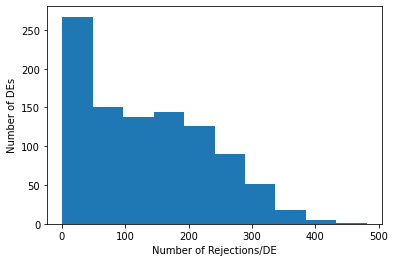

In [222]:
(heights, bins, _) = plt.hist(df.DE_ID.value_counts())
plt.xlabel('Number of Rejections/DE')
plt.ylabel('Number of DEs')
plt.show()

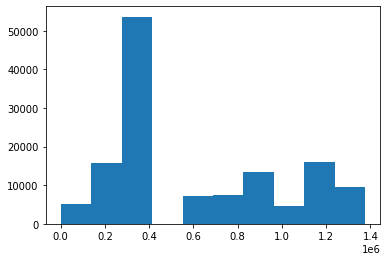

In [223]:
(_,_,_) = plt.hist(df.DE_ID)

In [224]:
num_defaults = df.DE_ID.map(df.DE_ID.value_counts())
bins = np.linspace(0,550,11,endpoint = False)
labels = np.linspace(1,10,10)
de_id_binned = pd.cut(num_defaults, bins, labels = labels)

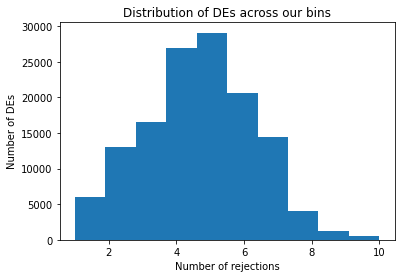

In [225]:
plt.hist(de_id_binned)
plt.xlabel("Number of rejections")
plt.ylabel("Number of DEs")
plt.title("Distribution of DEs across our bins")
plt.show()

#FEATURE #1 DE_ID_BINNED
####de_id_binned can be a better feature than DE_ID itself. But again its all a gamble

reject_type, Customer zone, DE_zone

In [226]:
reject_type_encoder = ce.OneHotEncoder(cols = ['reject_type'], use_cat_names= True)
reject_type_encoded = reject_type_encoder.fit_transform(df.reject_type)
reject_type_encoded.drop('reject_type_Type-0', inplace = True, axis = 1)

czone_encoder = ce.OneHotEncoder(cols = ['CUSTOMER_ZONE'], use_cat_names = False)
czone_encoded = czone_encoder.fit_transform(df.CUSTOMER_ZONE)

dezone_encoder = ce.OneHotEncoder(cols = ['DE_ZONE_ID'], use_cat_names = False)
dezone_encoded = dezone_encoder.fit_transform(df.DE_ZONE_ID)

In [227]:
czone_encoded.head()

,CUSTOMER_ZONE_1,CUSTOMER_ZONE_2,CUSTOMER_ZONE_3,CUSTOMER_ZONE_4,CUSTOMER_ZONE_5,CUSTOMER_ZONE_6,CUSTOMER_ZONE_7,CUSTOMER_ZONE_8
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


In [228]:
dezone_encoded.head()

,DE_ZONE_ID_1,DE_ZONE_ID_2,DE_ZONE_ID_3,DE_ZONE_ID_4,DE_ZONE_ID_5,DE_ZONE_ID_6,DE_ZONE_ID_7,DE_ZONE_ID_8
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0


In [229]:
reject_type_encoded.head()

,reject_type_Type-4,reject_type_Type-1,reject_type_Type-2,reject_type_Type-3
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


#FEATURES: REJECT TYPE, DE_ZONE, CUSTOMER_ZONE ENCODED

#Approach 1 for dealing with time series: 
 - simply use pd.to_numeric() on all time_stamp columns. 

In [230]:
df.head()

,DE_ID,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,reject_ind,reject_type,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,LAST_PING_TIME_LAST10MIN,CUSTOMER_ZONE,CUSTOMER_LAT,CUSTOMER_LNG,SHIFT_END_TIME,DE_HOME_LAT,DE_HOME_LNG,DE_JOINING_DATE,DE_ZONE_ID
0,180976,2021-02-13 03:08:24,2021-02-13 03:38:26,0,Type-0,320.9,320.0,314.0,1810.0,63,2021-02-13 03:07:34,373.0,37.377569,72.832560,05:42:00,37.374634,72.871986,2019-10-25,373
1,180976,2021-02-15 03:36:24,2021-02-15 03:54:31,0,Type-0,370.4,414.5,378.2,3710.0,52,2021-02-15 03:36:19,373.0,37.368782,72.809458,05:42:00,37.374634,72.871986,2019-10-25,373
2,180976,2021-03-04 04:57:21,2021-03-04 05:23:19,0,Type-0,408.2,320.0,397.2,2760.0,9,2021-03-04 04:56:33,373.0,37.374205,72.827956,05:42:00,37.374634,72.871986,2019-10-25,373
3,180976,2021-02-13 00:12:40,2021-02-13 01:02:36,0,Type-0,389.6,342.8,382.5,2210.0,16,2021-02-13 00:12:27,373.0,37.369154,72.815318,05:42:00,37.374634,72.871986,2019-10-25,373
4,180976,2021-02-25 04:08:34,2021-02-25 04:30:31,0,Type-0,392.3,418.1,351.3,2460.0,13,2021-02-25 04:07:58,373.0,37.376896,72.834044,05:42:00,37.374634,72.871986,2019-10-25,373


In [231]:
time_stamp_data = df.loc[:,('ASSIGNMENT_START_TIME', 'ASSIGNMENT_END_TIME', 'LAST_PING_TIME_LAST10MIN', 'SHIFT_END_TIME', 'DE_JOINING_DATE')]
for col in ['ASSIGNMENT_START_TIME', 'ASSIGNMENT_END_TIME', 'LAST_PING_TIME_LAST10MIN', 'DE_JOINING_DATE']:
  time_stamp_data[col] = pd.to_numeric(time_stamp_data[col])

time_stamp_data['SHIFT_END_TIME'] = time_stamp_data['SHIFT_END_TIME'].map(lambda x : x.hour*60 + x.minute)
# time_stamp_data['LAST_PING_TIME_LAST10MIN'] = pd.to_numeric(time_stamp_data['LAST_PING_TIME_LAST10MIN'])

In [232]:
time_stamp_data

,ASSIGNMENT_START_TIME,ASSIGNMENT_END_TIME,LAST_PING_TIME_LAST10MIN,SHIFT_END_TIME,DE_JOINING_DATE
0,1613185704000000000,1613187506000000000,1613185654000000000,342,1571961600000000000
1,1613360184000000000,1613361271000000000,1613360179000000000,342,1571961600000000000
2,1614833841000000000,1614835399000000000,1614833793000000000,342,1571961600000000000
3,1613175160000000000,1613178156000000000,1613175147000000000,342,1571961600000000000
4,1614226114000000000,1614227431000000000,1614226078000000000,342,1571961600000000000
...,...,...,...,...,...
132386,1614471752000000000,1614471932000000000,1614471638000000000,342,1600387200000000000
132387,1614462632000000000,1614469027000000000,1614462599000000000,342,1600387200000000000
132388,1614472112000000000,1614472292000000000,1614472069000000000,342,1600387200000000000
132389,1614045272000000000,1614046555000000000,1614045252000000000,402,1595635200000000000


#APPROACH 2: FEATURE ENGINEERING FROM RESPECTIVE SERIES.
we will see if we have to discard any of the derived features during EDA

In [233]:
time_stamp_data = df.loc[:,('ASSIGNMENT_START_TIME', 'ASSIGNMENT_END_TIME', 'LAST_PING_TIME_LAST10MIN', 'SHIFT_END_TIME', 'DE_JOINING_DATE')]
MONTH = time_stamp_data['ASSIGNMENT_START_TIME'].dt.month
DAY = time_stamp_data['ASSIGNMENT_END_TIME'].dt.weekday
ASSIGNMENT_TIME = (time_stamp_data['ASSIGNMENT_END_TIME'] - time_stamp_data['ASSIGNMENT_START_TIME']).astype('timedelta64[s]')
PING_TO_START = (time_stamp_data['ASSIGNMENT_START_TIME'] - time_stamp_data['LAST_PING_TIME_LAST10MIN']).astype('timedelta64[s]')
DE_JOINING_DATE = pd.to_numeric(time_stamp_data['DE_JOINING_DATE'])
shift_encoder = ce.OneHotEncoder(time_stamp_data['SHIFT_END_TIME'])
shift_encoded = shift_encoder.fit_transform(time_stamp_data['SHIFT_END_TIME'])
# TIME = time_stamp_data['ASSIGNMENT_START_TIME'].dt.time
# TIME = TIME.map(lambda timestamp: 60*60*timestamp.hour + 60*timestamp.minute + 60*timestamp.second)

# bins = np.linspace(TIME.min(),TIME.max(),5)
# QUARTER = pd.cut(TIME, bins, labels = [1,2,3, 4])
# QUARTER_encoder = ce.OneHotEncoder(QUARTER)
# QUARTERS = QUARTER_encoder.fit_transform(QUARTER)



#FEATURE #3 TIME STAMP DERIVED FEATURES

<hr>


###JOINING DERIVED FEATURES WITH MAIN DATASET: 

Derived features: <br>
- month, day, assignment_time, ping_to_start, de_joining_time
- reject_type_encoded, dezone_encoded, czone_encoded
- DE_ID_BINNED
- shift_encoded. 

COLUMNS TO REMOVE AFTER: 
- 'ASSIGNMENT_START_TIME', 'ASSIGNMENT_END_TIME', 'LAST_PING_TIME_LAST10MIN', 'SHIFT_END_TIME', 'DE_JOINING_DATE'
- reject_type, CUSTOMER_ZONE, DE_ZONE
- DE_ID

In [234]:
df_1 = pd.concat([df,reject_type_encoded, dezone_encoded, czone_encoded, shift_encoded],axis = 1)
df_1['DE_ID_BINNED'] = de_id_binned
df_1['MONTH'] = MONTH
df_1['DAY']  = DAY
df_1['ASSIGNMENT_TIME'] = ASSIGNMENT_TIME
df_1['PING_TO_START'] = PING_TO_START
df_1['DE_JOINING_DATE'] = DE_JOINING_DATE

In [235]:
df_1.drop(labels = ['ASSIGNMENT_START_TIME', 'ASSIGNMENT_END_TIME', 'LAST_PING_TIME_LAST10MIN', 'SHIFT_END_TIME', 'DE_JOINING_DATE', 'DE_ID', 'reject_type', 'CUSTOMER_ZONE', 'DE_ZONE_ID'], axis = 1, inplace = True)
print(df_1.shape)
df_1.head()


(132391, 41)


,reject_ind,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,CUSTOMER_LAT,CUSTOMER_LNG,DE_HOME_LAT,DE_HOME_LNG,reject_type_Type-4,reject_type_Type-1,reject_type_Type-2,reject_type_Type-3,DE_ZONE_ID_1,DE_ZONE_ID_2,DE_ZONE_ID_3,DE_ZONE_ID_4,DE_ZONE_ID_5,DE_ZONE_ID_6,DE_ZONE_ID_7,DE_ZONE_ID_8,CUSTOMER_ZONE_1,CUSTOMER_ZONE_2,CUSTOMER_ZONE_3,CUSTOMER_ZONE_4,CUSTOMER_ZONE_5,CUSTOMER_ZONE_6,CUSTOMER_ZONE_7,CUSTOMER_ZONE_8,SHIFT_END_TIME_1,SHIFT_END_TIME_2,SHIFT_END_TIME_3,SHIFT_END_TIME_4,SHIFT_END_TIME_5,SHIFT_END_TIME_6,DE_ID_BINNED,MONTH,DAY,ASSIGNMENT_TIME,PING_TO_START
0,0,320.9,320.0,314.0,1810.0,63,37.377569,72.832560,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,2,5,1802.0,50.0
1,0,370.4,414.5,378.2,3710.0,52,37.368782,72.809458,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,2,0,1087.0,5.0
2,0,408.2,320.0,397.2,2760.0,9,37.374205,72.827956,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,3,3,1558.0,48.0
3,0,389.6,342.8,382.5,2210.0,16,37.369154,72.815318,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,2,5,2996.0,13.0
4,0,392.3,418.1,351.3,2460.0,13,37.376896,72.834044,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,2,3,1317.0,36.0


#EXPLORATORY DATA ANALYSIS

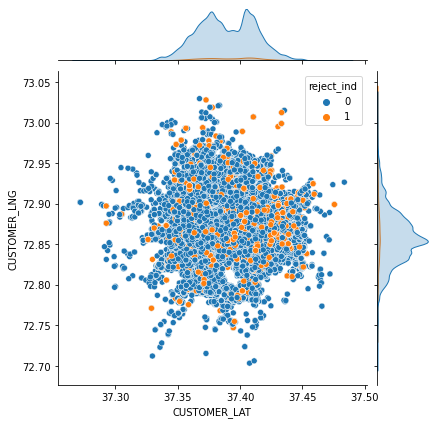

In [236]:
sns.jointplot(x = df.CUSTOMER_LAT, y = df.CUSTOMER_LNG, hue = df.reject_ind)

* missing values - done
* removing redundant columns -done
* data cleaning - done
* Merging the datasets - done
* feature engineering - done
* joining derived features with main dataset - done
* Exploratory data analysis
* normalization

#### this was quite a bummer, I was expecting a ring of fire around the city.

In [237]:
df_1.columns

Index(['reject_ind', 'LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE',
       'LAST_MILE_TIME_PREDICTED', 'PAYOUT_MADE_TO_DE',
       'NUM_PING_COUNT_LAST10MIN', 'CUSTOMER_LAT', 'CUSTOMER_LNG',
       'DE_HOME_LAT', 'DE_HOME_LNG', 'reject_type_Type-4',
       'reject_type_Type-1', 'reject_type_Type-2', 'reject_type_Type-3',
       'DE_ZONE_ID_1', 'DE_ZONE_ID_2', 'DE_ZONE_ID_3', 'DE_ZONE_ID_4',
       'DE_ZONE_ID_5', 'DE_ZONE_ID_6', 'DE_ZONE_ID_7', 'DE_ZONE_ID_8',
       'CUSTOMER_ZONE_1', 'CUSTOMER_ZONE_2', 'CUSTOMER_ZONE_3',
       'CUSTOMER_ZONE_4', 'CUSTOMER_ZONE_5', 'CUSTOMER_ZONE_6',
       'CUSTOMER_ZONE_7', 'CUSTOMER_ZONE_8', 'SHIFT_END_TIME_1',
       'SHIFT_END_TIME_2', 'SHIFT_END_TIME_3', 'SHIFT_END_TIME_4',
       'SHIFT_END_TIME_5', 'SHIFT_END_TIME_6', 'DE_ID_BINNED', 'MONTH', 'DAY',
       'ASSIGNMENT_TIME', 'PING_TO_START'],
      dtype='object')

In [238]:
#COLLECTING THE FEATURES THAT ARE CONTINUOUS VARIABLES;
proj = df_1.loc[:,('LASTMILE_DISTANCE','FIRSTMILE_DISTANCE','LAST_MILE_TIME_PREDICTED','PAYOUT_MADE_TO_DE','NUM_PING_COUNT_LAST10MIN','ASSIGNMENT_TIME','PING_TO_START')]
proj.corr()

,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,LAST_MILE_TIME_PREDICTED,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,ASSIGNMENT_TIME,PING_TO_START
LASTMILE_DISTANCE,1.000000,0.141388,0.812690,0.647271,-0.062587,0.283860,0.009928
FIRSTMILE_DISTANCE,0.141388,1.000000,0.128451,0.173776,0.116912,0.034228,-0.014501
LAST_MILE_TIME_PREDICTED,0.812690,0.128451,1.000000,0.475771,-0.066383,0.357955,0.007902
PAYOUT_MADE_TO_DE,0.647271,0.173776,0.475771,1.000000,0.020726,0.446833,-0.084857
NUM_PING_COUNT_LAST10MIN,-0.062587,0.116912,-0.066383,0.020726,1.000000,-0.043127,-0.159644
ASSIGNMENT_TIME,0.283860,0.034228,0.357955,0.446833,-0.043127,1.000000,-0.059596
PING_TO_START,0.009928,-0.014501,0.007902,-0.084857,-0.159644,-0.059596,1.000000


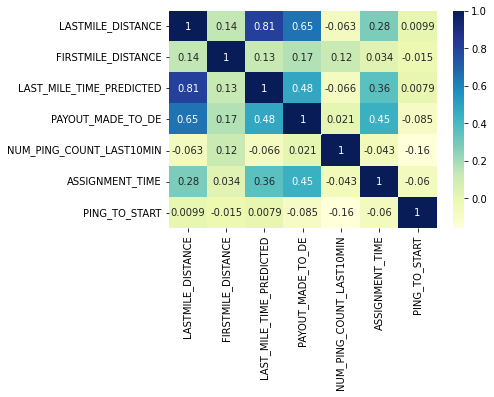

In [248]:
dataplot = sns.heatmap(proj.corr(),cmap = "YlGnBu", annot = True)
plt.show()

we can see that there is a high correlation between LASTMILE_DISTANCE AND LAST_MILE_TIME_PREDICTED. So it is only logical to remove one of them. 


In [239]:
df_1.drop(columns = ['LAST_MILE_TIME_PREDICTED']  ,inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


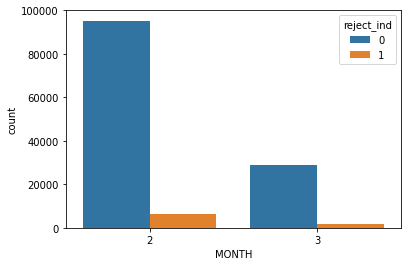

In [240]:
sns.countplot(df_1.MONTH,hue= df_1.reject_ind)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


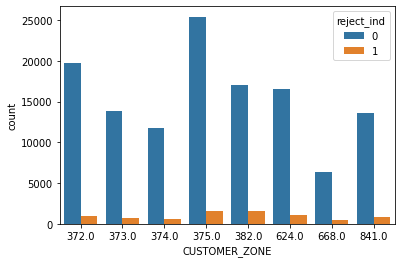

In [241]:
sns.countplot(df.CUSTOMER_ZONE, hue = df.reject_ind)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


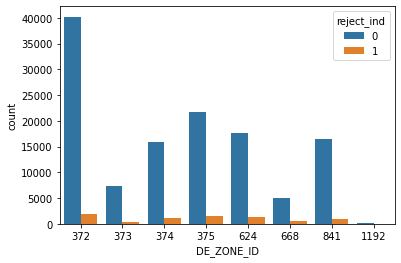

In [242]:
sns.countplot(df.DE_ZONE_ID,hue = df.reject_ind)

In [243]:
df.CUSTOMER_ZONE.value_counts()

375.0    26945
372.0    20807
382.0    18550
624.0    17636
373.0    14620
841.0    14518
374.0    12380
668.0     6935
Name: CUSTOMER_ZONE, dtype: int64

In [244]:
df_1.head()

,reject_ind,LASTMILE_DISTANCE,FIRSTMILE_DISTANCE,PAYOUT_MADE_TO_DE,NUM_PING_COUNT_LAST10MIN,CUSTOMER_LAT,CUSTOMER_LNG,DE_HOME_LAT,DE_HOME_LNG,reject_type_Type-4,reject_type_Type-1,reject_type_Type-2,reject_type_Type-3,DE_ZONE_ID_1,DE_ZONE_ID_2,DE_ZONE_ID_3,DE_ZONE_ID_4,DE_ZONE_ID_5,DE_ZONE_ID_6,DE_ZONE_ID_7,DE_ZONE_ID_8,CUSTOMER_ZONE_1,CUSTOMER_ZONE_2,CUSTOMER_ZONE_3,CUSTOMER_ZONE_4,CUSTOMER_ZONE_5,CUSTOMER_ZONE_6,CUSTOMER_ZONE_7,CUSTOMER_ZONE_8,SHIFT_END_TIME_1,SHIFT_END_TIME_2,SHIFT_END_TIME_3,SHIFT_END_TIME_4,SHIFT_END_TIME_5,SHIFT_END_TIME_6,DE_ID_BINNED,MONTH,DAY,ASSIGNMENT_TIME,PING_TO_START
0,0,320.9,320.0,1810.0,63,37.377569,72.832560,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,2,5,1802.0,50.0
1,0,370.4,414.5,3710.0,52,37.368782,72.809458,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,2,0,1087.0,5.0
2,0,408.2,320.0,2760.0,9,37.374205,72.827956,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,3,3,1558.0,48.0
3,0,389.6,342.8,2210.0,16,37.369154,72.815318,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,2,5,2996.0,13.0
4,0,392.3,418.1,2460.0,13,37.376896,72.834044,37.374634,72.871986,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5.0,2,3,1317.0,36.0


In [245]:
df_1.columns

Index(['reject_ind', 'LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE',
       'PAYOUT_MADE_TO_DE', 'NUM_PING_COUNT_LAST10MIN', 'CUSTOMER_LAT',
       'CUSTOMER_LNG', 'DE_HOME_LAT', 'DE_HOME_LNG', 'reject_type_Type-4',
       'reject_type_Type-1', 'reject_type_Type-2', 'reject_type_Type-3',
       'DE_ZONE_ID_1', 'DE_ZONE_ID_2', 'DE_ZONE_ID_3', 'DE_ZONE_ID_4',
       'DE_ZONE_ID_5', 'DE_ZONE_ID_6', 'DE_ZONE_ID_7', 'DE_ZONE_ID_8',
       'CUSTOMER_ZONE_1', 'CUSTOMER_ZONE_2', 'CUSTOMER_ZONE_3',
       'CUSTOMER_ZONE_4', 'CUSTOMER_ZONE_5', 'CUSTOMER_ZONE_6',
       'CUSTOMER_ZONE_7', 'CUSTOMER_ZONE_8', 'SHIFT_END_TIME_1',
       'SHIFT_END_TIME_2', 'SHIFT_END_TIME_3', 'SHIFT_END_TIME_4',
       'SHIFT_END_TIME_5', 'SHIFT_END_TIME_6', 'DE_ID_BINNED', 'MONTH', 'DAY',
       'ASSIGNMENT_TIME', 'PING_TO_START'],
      dtype='object')

In [249]:
df_1.to_csv('final_data.csv')

#PART 2 OF THE CASE STUDY

In [6]:
data_stock = pd.read_csv('./final_data.csv')
data_stock.drop(columns = ['Unnamed: 0'],inplace = True)
X_COLS = ('LASTMILE_DISTANCE', 'FIRSTMILE_DISTANCE',
       'PAYOUT_MADE_TO_DE', 'NUM_PING_COUNT_LAST10MIN', 'CUSTOMER_LAT',
       'CUSTOMER_LNG', 'DE_HOME_LAT', 'DE_HOME_LNG',
       'DE_ZONE_ID_1', 'DE_ZONE_ID_2', 'DE_ZONE_ID_3', 'DE_ZONE_ID_4',
       'DE_ZONE_ID_5', 'DE_ZONE_ID_6', 'DE_ZONE_ID_7', 'DE_ZONE_ID_8',
       'CUSTOMER_ZONE_1', 'CUSTOMER_ZONE_2', 'CUSTOMER_ZONE_3',
       'CUSTOMER_ZONE_4', 'CUSTOMER_ZONE_5', 'CUSTOMER_ZONE_6',
       'CUSTOMER_ZONE_7', 'CUSTOMER_ZONE_8', 'SHIFT_END_TIME_1',
       'SHIFT_END_TIME_2', 'SHIFT_END_TIME_3', 'SHIFT_END_TIME_4',
       'SHIFT_END_TIME_5', 'SHIFT_END_TIME_6', 'DE_ID_BINNED', 'MONTH', 'DAY',
       'ASSIGNMENT_TIME', 'PING_TO_START')
Y_COLS = ('reject_ind', 'reject_type_Type-4',
       'reject_type_Type-1', 'reject_type_Type-2', 'reject_type_Type-3')
data = data_stock.copy(deep = True)
X_DATA = data.loc[:,X_COLS]
Y_DATA = data.loc[:,Y_COLS]

# X_data = data_stock()
Y_DATA.head()

,reject_ind,reject_type_Type-4,reject_type_Type-1,reject_type_Type-2,reject_type_Type-3
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


#SCALING DATA

In [7]:
scaler_object = RobustScaler().fit(X_DATA)
scaled_data_X = scaler_object.transform(X_DATA)

#TRAIN TEST SPLIT

In [8]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data_X, Y_DATA, test_size=0.3, random_state=42, stratify = Y_DATA.reject_ind)

In [9]:
y_train.reject_ind.value_counts()

0    87039
1     5634
Name: reject_ind, dtype: int64

In [10]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

#SVM CLASSIFIER

In [12]:
classifier = SVC()
classifier.fit(X_train, y_train[:,[0]])
y_pred = classifier.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test[:,[0]], y_pred))
print("F1_Score: ", f1_score(y_test[:,[0]], y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score:  0.9998237574903066
F1_Score:  0.9985492227979275


####What went Missing
* Class imbalance (biased ratio of rejected to accepted cases): Could have been rectified by using smote oversampling.
* Geolocation data could have been categorized using K-Means clustering.
* Some more Visual Data Analysis could have been done.
* A more robust method to deal with outliers. Removing outliers directly, causes deletion of most of the rejected orders from the dataset.
* More observations can be derived from the Geolocation data columns.




Because of lack of time due to my end-semester examinations going on right now, I tried to clean the data, derive observations and generate new features based on those observations as well as I could, given the limited time and tight submission deadline. 

#PART 3 OF THE CASE STUDY

##Challenges that might arise 
* This model is to be used to determine whether a delivery executive will reject a delivery assignment or not.
* As is was mentioned in the workflow that for every assignment every one of the DEs is evaluated, and the order if finally assigned to one of these DEs.
* The SVM classifier can be useful here. While evaluating the DEs, the likeliness of the DE rejecting the assignment can be evaluated using the SVM and avoid assigning in case of high likeliness.
* One of the challenges faced during the production can be that the live update of data. 
* Once the dataset is updated every fixed time interval, new data is being added continuously.
* F1_score gives equal weight to precision and recall, but during deployment We might sometimes need to include domain knowledge in our evaluation where we want to have more recall or more precision.  